## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

Plotted the clusters for the train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y = None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=3, alpha=0.7) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [7]:
def plot_figure(title, X, y = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plot_clusters(X, y)
    plt.show()

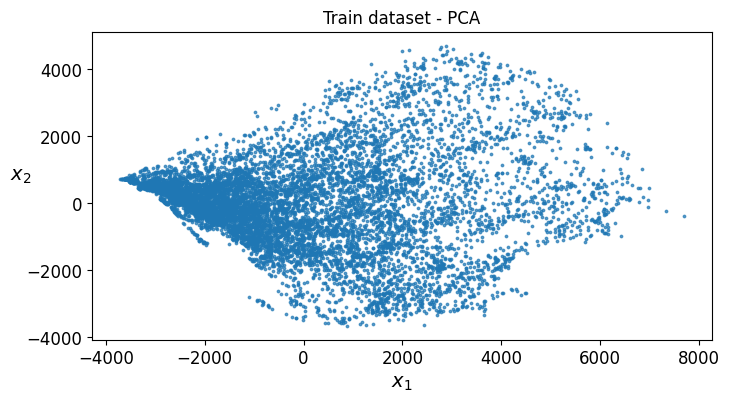

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca1)

Preprocessed the train dataset by winsorizing and normalising the data.

In [9]:
# Created a list to store the labels that have less number of pictures
less_class_labels = [0, 5, 6, 7, 8, 9]

data_list = []
for index, row in x_train.iterrows():
    label = y_train.iloc[index, 0]
    image_data = row.values.reshape(48, 48)

    if label in less_class_labels:
        data_list.append((image_data, label))

subset_dataset = np.array(data_list, dtype=object)

print(subset_dataset.shape)

num_images_per_label = {label: np.sum(subset_dataset[:, 1] == label) for label in less_class_labels}

for label, num_images in num_images_per_label.items():
    print(f"Label {label}: {num_images} images")

(1830, 2)
Label 0: 210 images
Label 5: 210 images
Label 6: 360 images
Label 7: 240 images
Label 8: 540 images
Label 9: 270 images


In [10]:
def add_noise(feature_vector, noise_level=0.01):
    noise = np.random.normal(0, noise_level, feature_vector.shape)
    noisy_vector = feature_vector + noise
    return noisy_vector

In [11]:
def introduce_perturbations(feature_vector, perturbation_level=0.02):
    min_value = np.min(feature_vector)
    max_value = np.max(feature_vector)
    perturbations = np.random.uniform(-perturbation_level, perturbation_level, feature_vector.shape)
    perturbed_vector = feature_vector + perturbations * (max_value - min_value)
    return perturbed_vector

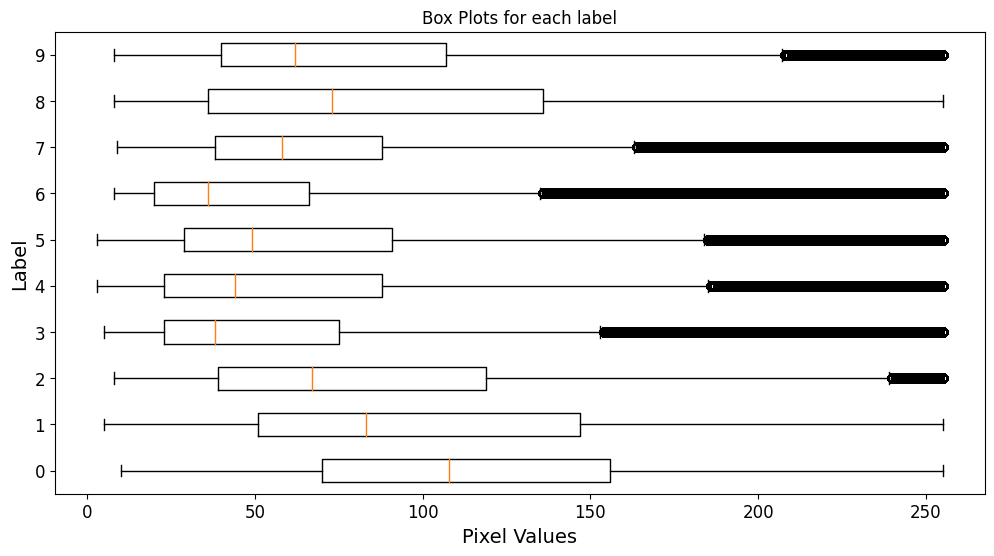

Label 0: 210 images
Label 1: 2220 images
Label 2: 2250 images
Label 3: 1410 images
Label 4: 1980 images
Label 5: 210 images
Label 6: 360 images
Label 7: 240 images
Label 8: 540 images
Label 9: 270 images


In [12]:
label_images = {}

num_images_per_label = {}

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)

for index, row in x_train.iterrows():
    label = y_train.iloc[index, 0]  
    image_data = row.values.reshape(-1, 48, 48) 

    if label not in label_images:
        label_images[label] = []
    
    label_images[label].append(image_data)

    num_images_per_label[label] = len(label_images[label])

box_data = np.array(list(label_images.values()), dtype=object)

labels = list(label_images.keys())

plt.figure(figsize=(12, 6))
plt.boxplot(box_data, labels=labels, vert=False)
plt.title("Box Plots for each label")
plt.xlabel("Pixel Values")
plt.ylabel("Label")
plt.show()

for label, num_images in num_images_per_label.items():
    print(f"Label {label}: {num_images} images")

In [13]:
from scipy.stats.mstats import winsorize

x_train = np.asarray(x_train)

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 50)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

In [14]:
import numpy as np
import random

# Assuming images are 48x48, we reshape the flat array into this shape for manipulation
image_shape = (48, 48)

def horizontal_flip(image):
    """ Flip the image horizontally """
    return image[:, ::-1]

def rotate_90(image):
    """ Rotate the image by 90 degrees """
    return np.rot90(image)

# Dummy data for illustration purposes
# x_train = np.array(...)  # Your image data loaded as a numpy array
y_train = np.asarray(y_train)  # Your labels loaded as a numpy array
y_train = y_train.ravel()

# The dictionary to hold the augmented images
augmented_images = {label: [] for label in range(10)}

# The target number of images per class
target_number = 2250

for label in range(10):
    # Filter images belonging to the current label
    images_indices = np.where(y_train == label)[0]
    images_of_label = x_train[images_indices]
    current_count = len(images_of_label)
    
    # Calculate the number of images to generate
    num_to_augment = target_number - current_count
    
    while num_to_augment > 0:
        # Loop through existing images and create augmented versions
        for image_index in images_indices:
            if num_to_augment <= 0:
                break
            # Reshape the image to 2D array for manipulation
            image = x_train[image_index].reshape(image_shape)
            # Randomly decide which augmentation to perform
            augmentation_choice = random.choice([horizontal_flip, rotate_90])
            # Perform the augmentation
            new_image = augmentation_choice(image).flatten()
            augmented_images[label].append(new_image)
            num_to_augment -= 1

# Combine original and augmented data
for label, images in augmented_images.items():
    if images:
        x_train = np.vstack((x_train, np.array(images)))
        y_train = np.concatenate((y_train, np.full(len(images), label)))

# Now x_train and y_train have been augmented to have balanced classes


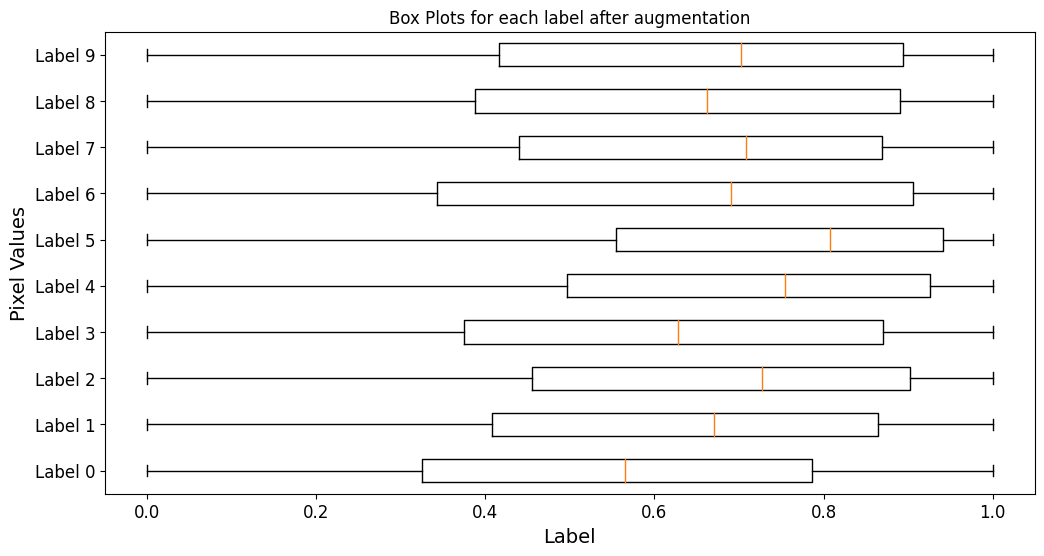

Label 0: 2250 images
Label 1: 2250 images
Label 2: 2250 images
Label 3: 2250 images
Label 4: 2250 images
Label 5: 2250 images
Label 6: 2250 images
Label 7: 2250 images
Label 8: 2250 images
Label 9: 2250 images


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming x_train is a DataFrame with each row being a flattened image and y_train is a Series or array of labels

# First, convert x_train to a numpy array if it's not already
x_train_array = x_train.values if isinstance(x_train, pd.DataFrame) else x_train

# Create a list to hold pixel data for each class
pixels_per_class = [[] for _ in range(10)]  # Adjust range if you have a different number of classes
label_per_class = {}
# Populate the list with pixel values
for label in range(10):  # Adjust range if you have a different number of classes
    # Get all the rows (images) for the current label
    rows_of_label = x_train_array[y_train == label]
    # Flatten each row and append to the respective class's pixel list
    for row in rows_of_label:
        pixels_per_class[label].extend(row)  # Assuming each row is a flattened image

    label_per_class[label] = len(rows_of_label)

# Now we can create a boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(pixels_per_class, labels=[f'Label {i}' for i in range(10)], vert=False)
plt.title('Box Plots for each label after augmentation')
plt.xlabel('Label')
plt.ylabel('Pixel Values')
plt.show()

for label, num_images in label_per_class.items():
    print(f"Label {label}: {num_images} images")


In [17]:
# print(x_train.shape)
# print(y_train.shape)
# print('------------------------')

# augmented_data = []
# new_augmented_data = []
# labels_for_train = []
# for data, label in subset_dataset:
#     #noisy_vector = add_noise(data, noise_level=0.01)  
#     perturbed_vector = introduce_perturbations(data, perturbation_level=0.02)  
    
#     # Append the original and augmented data with their respective labels
#     augmented_data.append((data, label))
#     #augmented_data.append((noisy_vector, label))
#     augmented_data.append((perturbed_vector, label))

# # Convert the appended data to a NumPy array
# for image_vectors, label_col in augmented_data:
#     new_augmented_data.append(image_vectors)
#     labels_for_train.append(label_col)

# new_augmented_data = np.array(new_augmented_data)
# labels_for_train = np.array(labels_for_train)

# new_labels = labels_for_train.reshape(-1, 1)

# new_augmented_data = new_augmented_data.reshape(new_augmented_data.shape[0], -1)

# print(new_augmented_data.shape)
# print(new_labels.shape)
# print('------------------------')
# if new_augmented_data.shape[1] == x_train.shape[1]:
#     x_train = np.vstack((x_train, new_augmented_data))
#     y_train = np.concatenate((y_train, new_labels))
# else:
#     print("Number of columns in appended_data doesn't match x_train.")

# print(x_train.shape)
# print(y_train.shape)

In [18]:
# label_images = {}

# num_images_per_label = {}

# x_train = pd.DataFrame(x_train)
# y_train = pd.DataFrame(y_train)

# for index, row in x_train.iterrows():
#     label = y_train.iloc[index, 0]  
#     image_data = row.values.reshape(-1, 48, 48) 

#     if label not in label_images:
#         label_images[label] = []
    
#     label_images[label].append(image_data)

#     num_images_per_label[label] = len(label_images[label])

# box_data = np.array(list(label_images.values()), dtype=object)

# labels = list(label_images.keys())

# plt.figure(figsize=(12, 6))
# plt.boxplot(box_data, labels=labels, vert=False)
# plt.title("Box Plots for each label")
# plt.xlabel("Pixel Values")
# plt.ylabel("Label")
# plt.show()

# for label, num_images in num_images_per_label.items():
#     print(f"Label {label}: {num_images} images")

In [19]:
# # Created a list to store the labels that have less number of pictures
# less_class_labels = [0, 5, 6, 7, 9]

# data_list = []
# for index, row in x_train.iterrows():
#     label = y_train.iloc[index, 0]
#     image_data = row.values.reshape(48, 48)

#     if label in less_class_labels:
#         data_list.append((image_data, label))

# subset_dataset = np.array(data_list, dtype=object)

# print(subset_dataset.shape)

# num_images_per_label = {label: np.sum(subset_dataset[:, 1] == label) for label in less_class_labels}

# for label, num_images in num_images_per_label.items():
#     print(f"Label {label}: {num_images} images")

In [20]:
# print(x_train.shape)
# print(y_train.shape)
# print('------------------------')

# augmented_data = []
# new_augmented_data = []
# labels_for_train = []
# for data, label in subset_dataset:
#     noisy_vector = add_noise(data, noise_level=0.01)  
#     perturbed_vector = introduce_perturbations(data, perturbation_level=0.02)  
    
#     # Append the original and augmented data with their respective labels
#     augmented_data.append((data, label))
#     augmented_data.append((noisy_vector, label))
#     augmented_data.append((perturbed_vector, label))

# # Convert the appended data to a NumPy array
# for image_vectors, label_col in augmented_data:
#     new_augmented_data.append(image_vectors)
#     labels_for_train.append(label_col)

# new_augmented_data = np.array(new_augmented_data)
# labels_for_train = np.array(labels_for_train)

# new_labels = labels_for_train.reshape(-1, 1)

# new_augmented_data = new_augmented_data.reshape(new_augmented_data.shape[0], -1)

# print(new_augmented_data.shape)
# print(new_labels.shape)
# print('------------------------')
# if new_augmented_data.shape[1] == x_train.shape[1]:
#     x_train = np.vstack((x_train, new_augmented_data))
#     y_train = np.concatenate((y_train, new_labels))
# else:
#     print("Number of columns in appended_data doesn't match x_train.")

# print(x_train.shape)
# print(y_train.shape)

In [21]:
import matplotlib.pyplot as plt

img = x_train.iloc[4391]
img = img.values.reshape((48, 48))

plt.imshow(img, cmap='gray')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
import cv2

ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh1,cmap='gray')

In [ ]:
# threshold_value = 120
# threshold_img_xtrain = "thresholded_images"

In [ ]:
# # Create the output folder if it doesn't exist
# if not os.path.exists(threshold_img_xtrain):
#     os.makedirs(threshold_img_xtrain)

# # Loop through the dataset and apply thresholding
# for i in range(len(x_train)):
#     img = x_train.iloc[i].values.reshape((48, 48))
#     ret, thresh1 = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
#     output_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
#     cv2.imwrite(output_path, thresh1)

In [ ]:
# thresholded_images = []
# for i in range(len(x_train)):
#     img_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     thresholded_images.append(img)

# x_train = np.array(thresholded_images)

In [ ]:
# x_train = np.asarray(x_train)

In [ ]:
# from scipy.stats.mstats import winsorize

# # Winsorize the data (adjust percentiles as needed)
# winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

# def normalise(images):
#     preprocessed_images = []
#     for image in images: 
#         if(len(image.shape) == 3):
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
#         if image.dtype != np.uint8:
#             image = image.astype(np.uint8)

#         adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 50)
#         enhanced_image = cv2.equalizeHist(adjusted)
#         image = enhanced_image/255.0
#         resize = cv2.resize(image, (48,48))

#         preprocessed_images.append(resize)
#     return  np.array(preprocessed_images)


# x_train = normalise(x_train)

# x_train = x_train.reshape(x_train.shape[0], -1)
# x_train.shape

In [ ]:
# #variance thresholdimg 

# from sklearn.feature_selection import VarianceThreshold

# # Set a threshold for variance (e.g., 0.1, but this value depends on your data)
# threshold_value = 0.15

# x_train = pd.DataFrame(x_train)
# # Instantiate the VarianceThreshold object
# selector = VarianceThreshold(threshold=threshold_value)

# # Assuming 'df' is your dataset
# # Fit the selector to the data
# selector.fit(x_train)

# # Get the indices of features to keep
# features_to_keep = selector.get_support(indices=True)

# # Create a new DataFrame with selected features
# df_high_variance = x_train.iloc[:, features_to_keep]


# x_train = np.asarray(df_high_variance)

Plotted the clusters again using PCA and also plotted the clusters using t-SNE for exploration.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca2)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

plot_figure("Train dataset - TSNE", x_train_tsne)

Applied K-Means clusterer on the dataset and received the silhouette score. Used k = 10 at the start, i.e., 10 clusters.

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_scaled)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

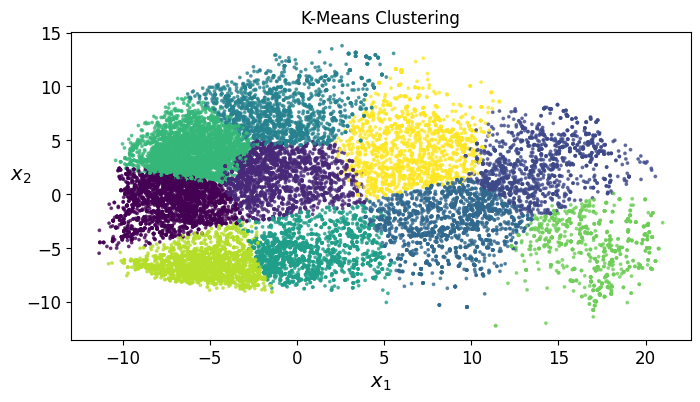

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [24]:
from sklearn.metrics import accuracy_score

y_train = np.asarray(y_train)

cluster_to_majority_class = {}
for cluster_label in np.unique(cluster_labels):
    cluster_mask = (cluster_labels == cluster_label)
    cluster_ground_truth_labels = y_train[cluster_mask].flatten()  # Flatten to 1D array
    majority_class = np.bincount(cluster_ground_truth_labels).argmax()
    print(majority_class)
    cluster_to_majority_class[cluster_label] = majority_class

print(len(cluster_labels))
print(cluster_labels)
# Assign majority class labels to all data points in each cluster
cluster_assigned_labels = [cluster_to_majority_class[label] for label in cluster_labels]

print(len(cluster_assigned_labels))
print(cluster_assigned_labels)

# Evaluate clustering accuracy
accuracy = accuracy_score(y_train, cluster_assigned_labels)  # Compare with ground truth labels
print(f"Clustering Accuracy: {accuracy}")

5
1
8
0
2
7
4
6
5
0
22500
[0 1 1 ... 5 3 3]
22500
[5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 5, 5, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 4, 1, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 6, 8, 8, 0, 0, 8, 0, 0, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 8, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 5, 1, 4, 4, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1, 5, 1, 4, 4, 4, 1, 1, 1, 4, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 8, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 1, 4, 4, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 7, 7, 1, 1, 1, 1, 1, 1, 2, 4, 4, 4, 2, 2, 2, 2, 2

In [25]:
print(np.unique(cluster_labels))
print(np.unique(cluster_assigned_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 4 5 6 7 8]


In [26]:
cluster_labels

array([0, 1, 1, ..., 5, 3, 3])

In [27]:
cluster_labels is kmeans.labels_

True

In [28]:
kmeans.inertia_

2100099.2881051213

In [29]:
kmeans.cluster_centers_

array([[-26.68602588,  -3.16584079],
       [ -4.72699542,   5.80629806],
       [ 52.96174989,  10.68009692],
       [ 33.51203096,  -9.09827795],
       [ -4.8877638 ,  27.87861561],
       [  2.51436906, -19.18148434],
       [-22.88974167,  13.33357769],
       [ 64.9006823 , -16.77853682],
       [-18.04683665, -23.75259604],
       [ 24.80836313,  15.99849955]])

In [30]:
kmeans.labels_

array([0, 1, 1, ..., 5, 3, 3])

In [31]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.3743440494581934


In [32]:
# Reference : https://colab.research.google.com/drive/1wq7JGYCT6Ctgd572KN9_QuIJwCS9tNo5?usp=sharing#scrollTo=7ZtUIKwNEcFS
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

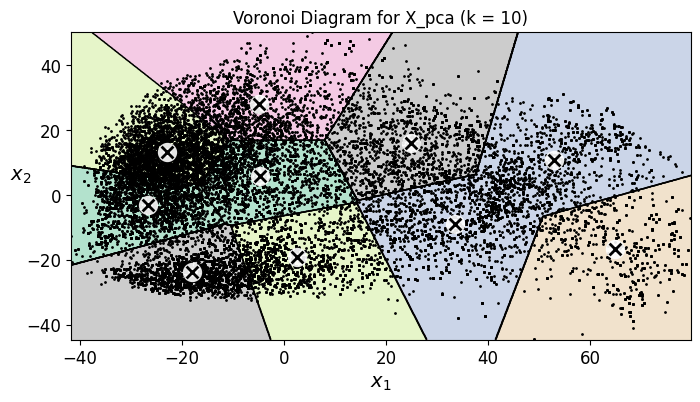

In [33]:
plt.figure(figsize=(8, 4))
plt.title("Voronoi Diagram for X_pca (k = 10)")
plot_decision_boundaries(kmeans, X_pca)
plt.show()

### 2) Hard & Soft Clustering

### 3) Determining Optimal Number of Clusters

In [34]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

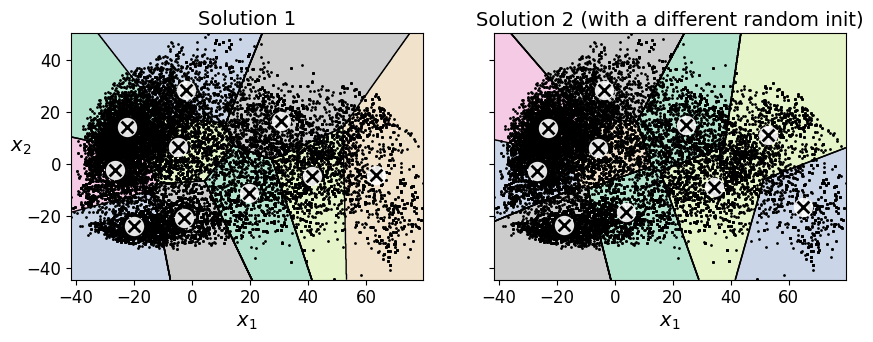

In [35]:
kmeans_rnd_init1 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=50)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X_pca,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

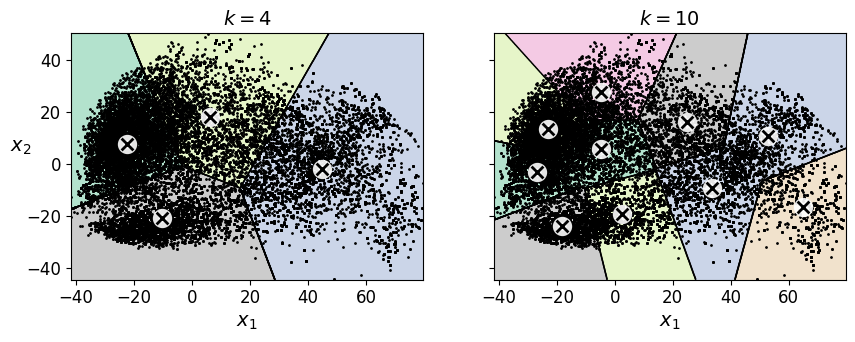

In [36]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_k10 = KMeans(n_clusters=10, random_state=42, n_init=10)

plot_clusterer_comparison(kmeans_k4, kmeans_k10, X_pca, "$k=4$", "$k=10$")
plt.show()

In [37]:
max_cluster=13
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

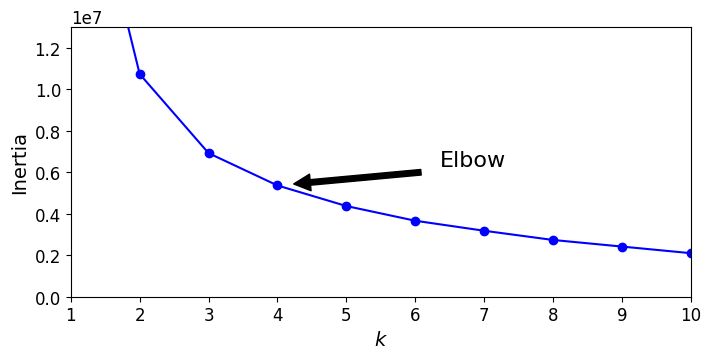

In [38]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_cluster), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 0, 13000000])  # Adjust the y-axis limit as needed
plt.show()


In [39]:
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 